# DEVANAGIRI HANDWRITTEN CHARACTER RECOGNITION

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

import PIL
from PIL import Image

import time
# tqdm for progress bars
from tqdm import tqdm

from pylab import *

Importing Labels

In [3]:
df_labels = pd.read_csv("labels.csv")
df_labels = df_labels.dropna()
df_labels = df_labels.drop_duplicates()
df_labels = df_labels.rename(columns={"Numerals" : "Class","Unnamed: 1":"Label","Unnamed: 2" : "Devanagari Label", "Unnamed: 3" : "Phonetics"})
df_labels = df_labels.drop(index=[1])
df_labels = df_labels.reset_index()
df_labels = df_labels.drop(columns=["index"],axis=1)

In [4]:
df_labels.loc[22]["Label"]

'ka'

In [5]:
def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = Image.open(f)
        nparr = np.asarray(img)
        # plt.imshow(nparr)
        nparr = nparr[:, :, np.newaxis]
        return nparr

In [6]:
def read_data_from_folder(folder_path, folder_name):
    imgs = []
    labels = []
    for folder in tqdm(os.listdir(folder_path)):
        sub_folder = os.path.join(folder_path, folder)
        for f in os.listdir(sub_folder):
            img = load_image_to_array(os.path.join(sub_folder, f))
            imgs.append(img)
            if folder_name == "consonants":
                labels.append(df_labels.loc[int(folder)+21]["Label"])
            elif folder_name == "vowels":
                labels.append(df_labels.loc[int(folder)+9]["Label"])
            elif folder_name == "numerals":
                labels.append(df_labels.loc[int(folder)]["Label"])

            
    return np.asarray(imgs), np.asarray(labels)

In [7]:
curr_path = os.getcwd()
consonants_path = os.path.join(curr_path,"nhcd/nhcd/consonants")
vowels_path = os.path.join(curr_path,"nhcd/nhcd/vowels")
numerals_path = os.path.join(curr_path,"nhcd/nhcd/numerals")


In [8]:
consonants_imgs, consonant_labels = read_data_from_folder(consonants_path, "consonants")
vowels_imgs, vowels_labels = read_data_from_folder(vowels_path, "vowels")
numerals_imgs, numerals_labels = read_data_from_folder(numerals_path, "numerals")


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


In [9]:
consonant_labels

array(['ka', 'ka', 'ka', ..., 'jha', 'jha', 'jha'], dtype='<U12')

In [10]:
print(consonants_imgs.shape[0])
print(vowels_imgs.shape[0])
print(numerals_imgs.shape[0])

7380
2652
2880


We perform stratified splitting of the data into train/test sets

In [11]:
from sklearn.model_selection import train_test_split

X_train_01, X_test_01, Y_train_01, Y_test_01 = train_test_split(consonants_imgs, consonant_labels)
X_train_02, X_test_02, Y_train_02, Y_test_02 = train_test_split(vowels_imgs, vowels_labels)
X_train_03, X_test_03, Y_train_03, Y_test_03 = train_test_split(numerals_imgs, numerals_labels)

In [12]:
X_train = np.concatenate((X_train_01, X_train_02, X_train_03))
Y_train = np.concatenate((Y_train_01, Y_train_02, Y_train_03))
X_test = np.concatenate((X_test_01, X_test_02, X_test_03))
Y_test = np.concatenate((Y_test_01, Y_test_02, Y_test_03))

In [13]:
X_train.shape

(9684, 28, 28, 1)

In [14]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
Y_train_Ordinal_encoded = ordinal_encoder.fit_transform(Y_train.reshape(-1,1))
Y_train_Ordinal_encoded = pd.DataFrame(Y_train_Ordinal_encoded)
Y_test_Ordinal_encoded = ordinal_encoder.transform(Y_test.reshape(-1,1))
Y_test_Ordinal_encoded = pd.DataFrame(Y_test_Ordinal_encoded)
train_Y = tf.keras.utils.to_categorical( Y_train_Ordinal_encoded, num_classes=58, dtype='float32')
test_Y = tf.keras.utils.to_categorical( Y_test_Ordinal_encoded, num_classes=58, dtype='float32')

In [15]:
ordinal_encoder.categories_

[array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'aa', 'ae',
        'ah', 'ai', 'an', 'ana', 'au', 'ba', 'bha', 'cha', 'chha', 'da',
        'daa', 'dha', 'dhaa', 'ee', 'ga', 'gha', 'gya', 'ha', 'i', 'ja',
        'jha', 'ka', 'kha', 'kna', 'ksha', 'la', 'ma', 'motosaw', 'na',
        'o', 'oo', 'pa', 'patalosaw', 'petchiryosaw', 'pha', 'ra', 'ta',
        'taa', 'tha', 'thaa', 'tra', 'u', 'va', 'ya', 'yna'], dtype='<U12')]

6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


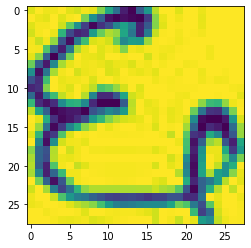

In [16]:
import random

rand = random.randrange(0, X_train.shape[0])
print(Y_train[rand])
print(train_Y[rand])
imshow(X_train[rand])

# Building CNN Architecture using Keras Tensorflow

In [17]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint

In [18]:
Number_of_Classes = df_labels.shape[0]

In [19]:
Number_of_Classes

58

In [20]:
model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(64, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
model.add(Flatten())
model.add(Dense(Number_of_Classes, activation='softmax'))

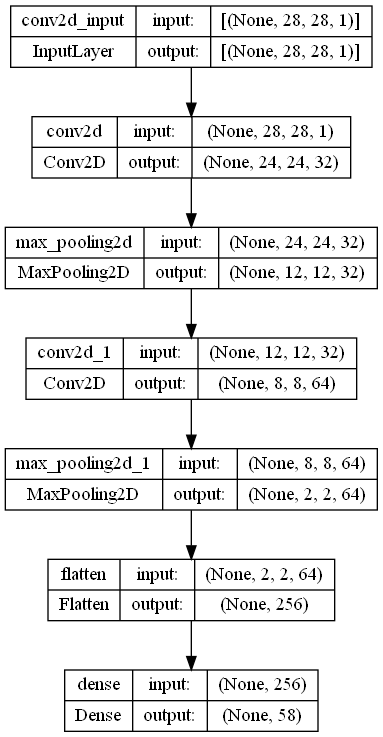

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile Model

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = "devanagari_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks_list = [checkpoint1]

In [23]:
history = model.fit(X_train, train_Y, validation_data=(X_test, test_Y), epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/10
152/152 [==============================] - 7s 44ms/step - loss: 3.9633 - accuracy: 0.0721 - val_loss: 3.5877 - val_accuracy: 0.1716
Epoch 2/10
152/152 [==============================] - 7s 45ms/step - loss: 2.8203 - accuracy: 0.3754 - val_loss: 2.2548 - val_accuracy: 0.4966
Epoch 3/10
152/152 [==============================] - 7s 45ms/step - loss: 1.8189 - accuracy: 0.6083 - val_loss: 1.6176 - val_accuracy: 0.6183
Epoch 4/10
152/152 [==============================] - 7s 44ms/step - loss: 1.3571 - accuracy: 0.7012 - val_loss: 1.2962 - val_accuracy: 0.6964
Epoch 5/10
152/152 [==============================] - 6s 42ms/step - loss: 1.0982 - accuracy: 0.7497 - val_loss: 1.1016 - val_accuracy: 0.7351
Epoch 6/10
152/152 [==============================] - 7s 43ms/step - loss: 0.9226 - accuracy: 0.7873 - val_loss: 0.9696 - val_accuracy: 0.7643
Epoch 7/10
152/152 [==============================] - 7s 43ms/step - loss: 0.8084 - accuracy: 0.8158 - val_loss: 0.9231 - val_accuracy: 0.7742

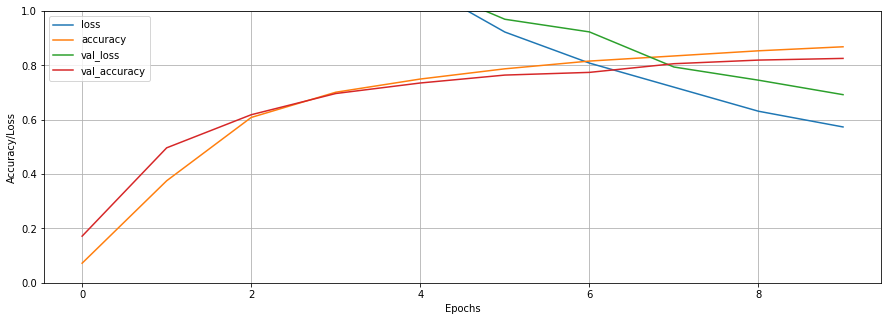

In [24]:
pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.show()

In [25]:
scores = model.evaluate(X_test, test_Y, verbose=0)
print("The accuracy on test set is :", 100*scores[1],"%")

The accuracy on test set is : 82.5588583946228 %


In [26]:
def predict_class(x):
    X_new = X_test[x:x+1]
    y_proba = model.predict(X_new)
    return np.array(ordinal_encoder.categories_).reshape(-1,1)[np.argmax(y_proba,axis=1)][0,0]
    

Actual Label : da
1/1 [==============================] - 0s 133ms/step
Predicted Label : da


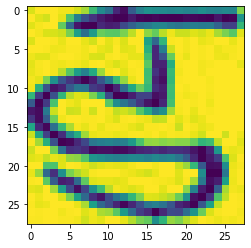

In [27]:
rand2 = random.randrange(0, X_test.shape[0])
print("Actual Label :",Y_test[rand2])
imshow(X_test[rand2])
print("Predicted Label :",predict_class(rand2))

## LeNet Model

In [28]:
model_LeNet = keras.models.Sequential()
model_LeNet.add(Conv2D(filters=6, kernel_size=(5, 5), input_shape=(28, 28, 1), padding ="same", activation='tanh'))
model_LeNet.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model_LeNet.add(Conv2D(16, (5, 5), activation='tanh'))
model_LeNet.add(AveragePooling2D(pool_size=(2,2), strides= 2))
model_LeNet.add(Conv2D(120, (5, 5), activation='tanh'))
model_LeNet.add(Flatten())
model_LeNet.add(Dense(84, activation='tanh'))
model_LeNet.add(Dense(Number_of_Classes, activation='softmax'))

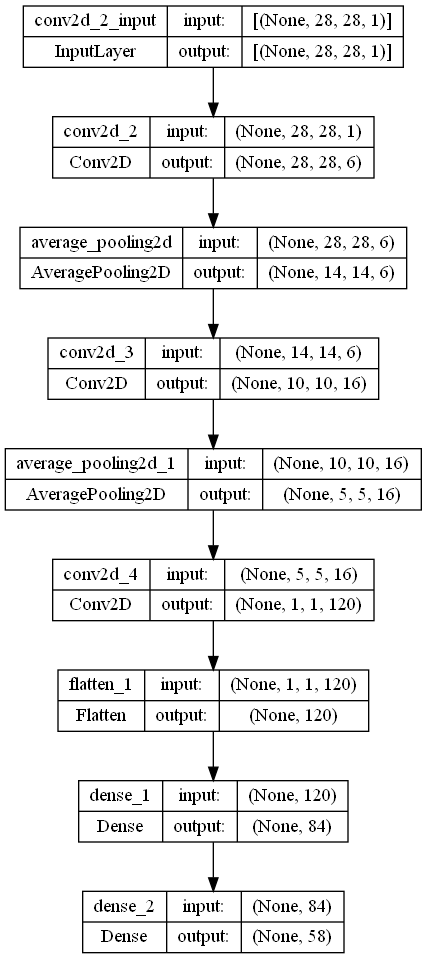

In [29]:
tf.keras.utils.plot_model(model_LeNet, show_shapes=True)

In [30]:
model_LeNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = "devanagari_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks_list = [early_stopping_cb]

In [31]:
history = model_LeNet.fit(X_train, train_Y, validation_data=(X_test, test_Y), epochs=100, batch_size=64, callbacks=callbacks_list)

Epoch 1/100
152/152 [==============================] - 4s 23ms/step - loss: 2.7251 - accuracy: 0.3634 - val_loss: 1.8451 - val_accuracy: 0.5582
Epoch 2/100
152/152 [==============================] - 4s 23ms/step - loss: 1.4604 - accuracy: 0.6467 - val_loss: 1.3101 - val_accuracy: 0.6623
Epoch 3/100
152/152 [==============================] - 3s 22ms/step - loss: 1.0502 - accuracy: 0.7393 - val_loss: 1.0488 - val_accuracy: 0.7261
Epoch 4/100
152/152 [==============================] - 3s 22ms/step - loss: 0.8350 - accuracy: 0.7897 - val_loss: 0.9078 - val_accuracy: 0.7543
Epoch 5/100
152/152 [==============================] - 4s 23ms/step - loss: 0.6843 - accuracy: 0.8246 - val_loss: 0.7905 - val_accuracy: 0.7822
Epoch 6/100
152/152 [==============================] - 3s 23ms/step - loss: 0.5769 - accuracy: 0.8537 - val_loss: 0.7175 - val_accuracy: 0.8042
Epoch 7/100
152/152 [==============================] - 4s 23ms/step - loss: 0.4977 - accuracy: 0.8747 - val_loss: 0.6692 - val_accuracy:

In [32]:
scores = model_LeNet.evaluate(X_test, test_Y, verbose=0)
print("The accuracy on test set is :", 100*scores[1],"%")

The accuracy on test set is : 86.61710023880005 %


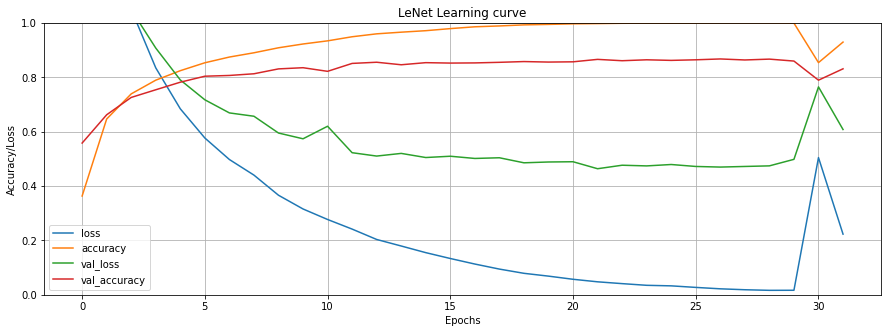

In [33]:
pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title("LeNet Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.show()

In [34]:
def predict_class(x):
    X_new = X_test[x:x+1]
    y_proba = model_LeNet.predict(X_new)
    return np.array(ordinal_encoder.categories_).reshape(-1,1)[np.argmax(y_proba,axis=1)][0,0]

Actual Label : 9
1/1 [==============================] - 0s 67ms/step
Predicted Label : 9


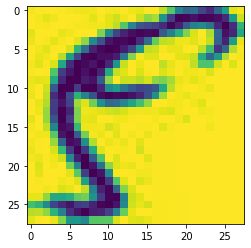

In [94]:
rand3 = random.randrange(0, X_test.shape[0])
print("Actual Label :",Y_test[rand3])
imshow(X_test[rand3])
print("Predicted Label :",predict_class(rand3))